<h1 style="color:#4A90E2;">CNA Analysis Notebook for Tissue-Based HCC Data from TCGA</h1>

This Jupyter notebook provides the code used to process and analyze 
copy number alterations (CNA) in hepatocellular carcinoma (HCC) tissue samples 
from <span style="color:#D35400;"><strong>The Cancer Genome Atlas (TCGA)</strong></span>. 
The analysis supports the Methods section of <strong>Chapter 2</strong> of the following thesis:

> <span style="color:#8E44AD;"><strong>Sultan N. Alharbi</strong></span>,  
> <em><span style="color:#8E44AD;">Circulating Tumour DNA as a Prognostic Biomarker for First-line Systemic Therapy Outcomes in Hepatocellular Carcinoma</span></em>,  
> Imperial College London, <strong>2026</strong>.

---

<h2 style="color:#27AE60;">Purpose of the Analysis</h2>

To assess whether cfDNA-derived CNA profiles capture tumour biology with high fidelity,  
these profiles were compared against tissue-based genomic data from the 
<span style="color:#D35400;"><strong>TCGA HCC cohort (n = 233)</strong></span>.  
The comparison revealed a **highly concordant** pattern of chromosomal arm-level alterations, including:

- <span style="color:#2980B9;">**Gains at 1q and 8q**</span>  
- <span style="color:#C0392B;">**Losses at 8p and 17p**</span>

These results demonstrate strong agreement between cfDNA-derived and tissue-derived CNA profiles,  
supporting the use of cfDNA as a reliable surrogate for tumour genomic alterations.

It includes:

- Summary statistics of gains and losses per chromosomal arm  
- Visualisation of gains and losses across arms (bar plot)  
- Distribution of arm-level CNAs across patients (donut chart)  
- Sample-by-arm heatmap of median copy number changes  


In [1]:
# -------------------------------------------------------------
# Imports
# -------------------------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# Matplotlib global style configuration
# -------------------------------------------------------------

# Font settings
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

# Axis aesthetics
plt.rcParams["axes.linewidth"] = 1.5
plt.rcParams["axes.edgecolor"] = "black"


## 1. Load TCGA HCC CNA Dataset

In this section, we load the arm-level CNA data exported from TCGA
for HCC tissue samples. The dataset is expected to contain at least:

- `sample` – patient/sample identifier  
- `chr` – chromosome (e.g. `"chr1"`, `"chr2"`, …)  
- `arm` – chromosomal arm (`"p"` or `"q"`)  
- `top_event` – categorical event label (e.g. `"Gains"`, `"Losses"`)  
- `median_bpWeighted` – continuous measure of CNA per arm

Please update the path below to match your local or project directory.


In [ ]:
# -------------------------------------------------------------
# Step 1: Load the TCGA CNA dataset
# -------------------------------------------------------------

data_path = (
    "Data/TCGA_combined_study_segments_233_samples.csv"
)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(data_path)

print("Dataset loaded successfully.")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

df.head()


Dataset loaded successfully.
Shape: (1407, 9)
Columns: ['sample', 'chr', 'arm', 'median_bpWeighted', 'total_bins', 'total_bpOverlap', 'top_event', 'top_event_bp', 'top_event_fraction']


,sample,chr,arm,median_bpWeighted,total_bins,total_bpOverlap,top_event,top_event_bp,top_event_fraction
0,P-0000037-T02-IM3,chr1,p,-0.349803,606.298872,217499038,Losses,193842682,0.891235
1,P-0000037-T02-IM3,chr1,q,0.506852,479.354954,239983416,Gains,188818524,0.786798
2,P-0000037-T02-IM3,chr16,p,-0.645500,204.014040,73549858,Losses,73549858,1.000000
3,P-0000037-T02-IM3,chr16,q,-0.645500,293.985959,105985968,Losses,105985968,1.000000
4,P-0000037-T02-IM3,chr2,p,-0.634600,364.329211,171665824,Losses,171665824,1.000000


## 2. Data Preparation: Chromosomal Arms and Event Categories

Here we:

- Create a combined chromosome-arm label (e.g. `"chr1p"`)  
- Define a consistent arm order across autosomes (chromosomes 1–22, `p` and `q`)  
- Classify events from the `top_event` column into three categories:
  - **Gains**
  - **Losses**


In [3]:
# -------------------------------------------------------------
# Step 2: Data preparation
# -------------------------------------------------------------

# Create combined chromosome-arm label, e.g. "chr1p"
df["chrom_arm"] = df["chr"] + df["arm"]

# Define autosomal arms 1p–22q in order
all_arms = [f"chr{i}{arm}" for i in range(1, 23) for arm in ["p", "q"]]

# Total number of unique samples
total_samples = df["sample"].nunique()
print(f"Total samples: {total_samples}")


def classify_event(top_event: str) -> str:
    """
    Classify CNA event into Gains, or Losses based on `top_event`.

    Parameters
    ----------
    top_event : str
        Original event label from the dataset (e.g. 'Gains', 'Losses').

    Returns
    -------
    str
        'Gains', or 'Losses'.
    """
    if top_event == "Gains":
        return "Gains"
    elif top_event == "Losses":
        return "Losses"
    else:
        return "Neutral"


# Apply classification to create a simplified category column
df["Category"] = df["top_event"].apply(classify_event)

df.head()


Total samples: 233


,sample,chr,arm,median_bpWeighted,total_bins,total_bpOverlap,top_event,top_event_bp,top_event_fraction,chrom_arm,Category
0,P-0000037-T02-IM3,chr1,p,-0.349803,606.298872,217499038,Losses,193842682,0.891235,chr1p,Losses
1,P-0000037-T02-IM3,chr1,q,0.506852,479.354954,239983416,Gains,188818524,0.786798,chr1q,Gains
2,P-0000037-T02-IM3,chr16,p,-0.645500,204.014040,73549858,Losses,73549858,1.000000,chr16p,Losses
3,P-0000037-T02-IM3,chr16,q,-0.645500,293.985959,105985968,Losses,105985968,1.000000,chr16q,Losses
4,P-0000037-T02-IM3,chr2,p,-0.634600,364.329211,171665824,Losses,171665824,1.000000,chr2p,Losses


## 3. Summary of Gains and Losses per Chromosomal Arm

In this section, we compute:

- The number of gains and losses per chromosomal arm  
- The number of samples with any abnormality (gain or loss) per arm  
- The percentage of samples with abnormalities per arm  

This provides a tabular overview of arm-level CNA burden across the cohort.


In [4]:
# -------------------------------------------------------------
# Step 3: Summarise gains and losses per chromosomal arm
# -------------------------------------------------------------


def calculate_cnv_stats_for_arm(arm_label: str, df_arm: pd.DataFrame) -> dict:
    """
    Calculate arm-level CNA statistics for a given chromosomal arm.

    Parameters
    ----------
    arm_label : str
        Chromosomal arm label (e.g. 'chr1p').
    df_arm : pandas.DataFrame
        DataFrame containing at least 'chrom_arm', 'sample', and 'top_event'.

    Returns
    -------
    dict
        Dictionary with counts of gains, losses, total abnormalities,
        and percentage of samples with any abnormality.
    """
    # Filter data for the specific arm
    sub_data = df_arm[df_arm["chrom_arm"] == arm_label]

    # Counts of gains and losses
    gains = sub_data["top_event"].value_counts().get("Gains", 0)
    losses = sub_data["top_event"].value_counts().get("Losses", 0)

    # Unique samples with Gains or Losses
    samples_with_abnormalities = sub_data[
        sub_data["top_event"].isin(["Gains", "Losses"])
    ]["sample"].nunique()

    # Percentage of samples with abnormalities
    total_percent = (
        samples_with_abnormalities / total_samples * 100 if total_samples else 0
    )

    return {
        "Chrom_Arm": arm_label,
        "Gains": gains,
        "Losses": losses,
        "Total_Abnormalities": samples_with_abnormalities,
        "Total_Percent": total_percent,
    }


# Compute summary statistics for all defined arms
results = [calculate_cnv_stats_for_arm(arm, df) for arm in all_arms]

summary_df = pd.DataFrame(results)

print("\nChromosomal Abnormality Summary:")
print("=" * 60)
print(summary_df.to_string(index=False))
print("=" * 60)

print("\nSummary Statistics:")
print(f"Total Gains: {summary_df['Gains'].sum()}")
print(f"Total Losses: {summary_df['Losses'].sum()}")
print(f"Total Abnormalities: {summary_df['Total_Abnormalities'].sum()}")
print(f"Average Total Percent: {summary_df['Total_Percent'].mean():.2f}%")



Chromosomal Abnormality Summary:
Chrom_Arm  Gains  Losses  Total_Abnormalities  Total_Percent
    chr1p     10      26                   36      15.450644
    chr1q    125       0                  125      53.648069
    chr2p      2       3                    5       2.145923
    chr2q      2       9                   11       4.721030
    chr3p      5       4                    9       3.862661
    chr3q      2       4                    6       2.575107
    chr4p     10      15                   25      10.729614
    chr4q      0      49                   49      21.030043
    chr5p     21       1                   22       9.442060
    chr5q     16       5                   21       9.012876
    chr6p     61       0                   61      26.180258
    chr6q      7      53                   60      25.751073
    chr7p     32       1                   33      14.163090
    chr7q     24       2                   26      11.158798
    chr8p      3     135                  138      

## 4. Visualisation: Gains and Losses per Chromosomal Arm (Bar Plot)

Here we generate a bar plot showing:

- The number of patients with **gains** per chromosomal arm  
- The number of patients with **losses** per chromosomal arm (plotted as negative values)

This provides a visual overview of which arms are most frequently gained or lost.


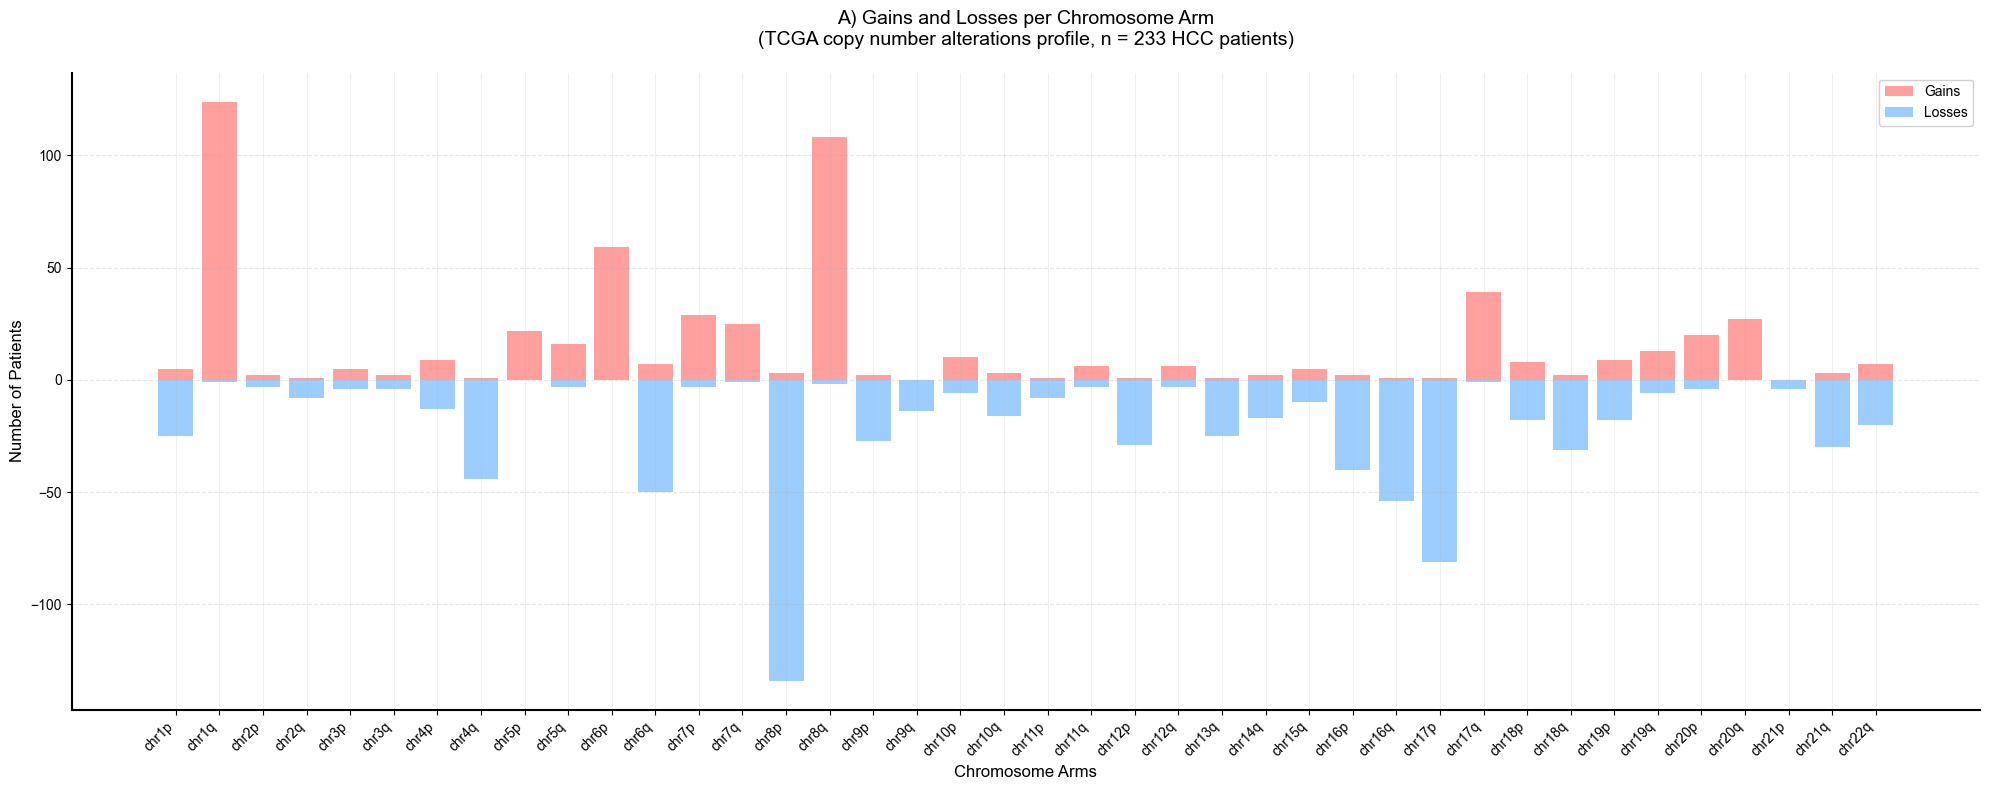

In [6]:
# -------------------------------------------------------------
# Step 4: Bar plot of gains and losses per chromosomal arm
# -------------------------------------------------------------

# Reuse df with 'chrom_arm' already defined
existing_arms = sorted(
    df["chrom_arm"].unique(),
    key=lambda x: (int("".join(filter(str.isdigit, x))), x[-1]),
)
df["chrom_arm"] = pd.Categorical(df["chrom_arm"], categories=existing_arms, ordered=True)


def get_arm_summary(df_plot: pd.DataFrame) -> pd.DataFrame:
    """
    Classify events based on median_bpWeighted and summarise counts per arm.

    - event = 'gain' if median_bpWeighted > 0.1
    - event = 'loss' if median_bpWeighted < -0.1
    - event = 'neutral' otherwise
    """
    df_plot = df_plot.copy()
    df_plot["event"] = "neutral"
    df_plot.loc[df_plot["median_bpWeighted"] > 0.1, "event"] = "gain"
    df_plot.loc[df_plot["median_bpWeighted"] < -0.1, "event"] = "loss"

    summary = (
        df_plot.groupby(["chrom_arm", "event"], observed=True)
        .size()
        .unstack(fill_value=0)
    )
    return summary


summary = get_arm_summary(df)

plt.figure(figsize=(20, 8))
x = np.arange(len(existing_arms))

plt.bar(x, summary["gain"], width=0.8, label="Gains", color="#ff7675", alpha=0.7)
plt.bar(x, -summary["loss"], width=0.8, label="Losses", color="#74b9ff", alpha=0.7)

plt.xticks(x, existing_arms, rotation=45, ha="right", fontsize=10)
plt.ylabel("Number of Patients", fontsize=12)
plt.xlabel("Chromosome Arms", fontsize=12)
plt.title(
    "A) Gains and Losses per Chromosome Arm\n"
    "(TCGA copy number alterations profile, n = 233 HCC patients)",
    fontsize=14,
    pad=20,
)

plt.grid(True, axis="y", alpha=0.3, linestyle="--")
plt.grid(True, axis="x", alpha=0.2, linestyle="-")
plt.legend(loc="upper right", framealpha=0.9)

ax = plt.gca()
ax.set_facecolor("white")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(
    "chromosome_gains_losses.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)
plt.show()


## 5. Visualisation: Distribution of Arm-Level CNAs (Donut Chart)

Next, we quantify the **percentage of patients** with any CNA (gain or loss)
on each chromosomal arm and display this as a donut chart.

This highlights which arms are most frequently altered across the cohort.


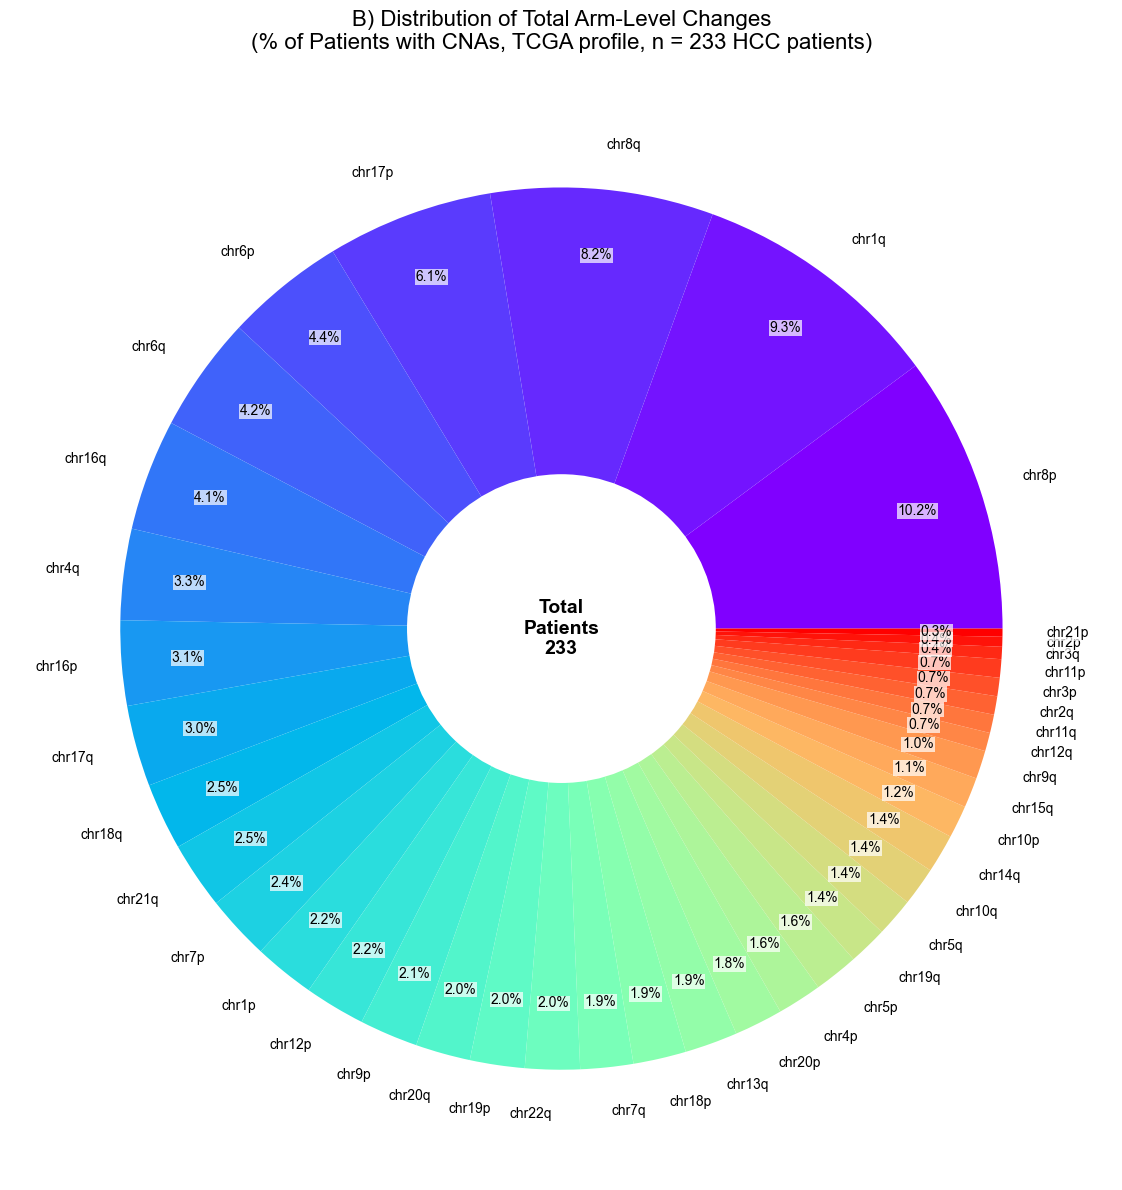

In [9]:
# -------------------------------------------------------------
# Step 5: Donut chart of arm-level CNA distribution
# -------------------------------------------------------------
# Classify events (gain / loss / neutral) based on median_bpWeighted.
# This reuses the same thresholds as in the bar plot:
#   - event = 'gain'  if median_bpWeighted >  0.1
#   - event = 'loss'  if median_bpWeighted < -0.1
#   - event = 'neutral' otherwise

df["event"] = "neutral"
df.loc[df["median_bpWeighted"] > 0.1, "event"] = "gain"
df.loc[df["median_bpWeighted"] < -0.1, "event"] = "loss"

# Count how many patients have any CNA (gain or loss) per chromosomal arm
total_events = (
    df[df["event"] != "neutral"]
    .groupby("chrom_arm", observed=True)
    .size()
)
total_patients = df["sample"].nunique()

# Convert to percentage of patients with a CNA on each arm
percentages = (total_events / total_patients * 100).round(1)

# Sort for clearer visual ordering (most frequently altered arms first)
percentages_sorted = percentages.sort_values(ascending=False)

# Colour gradient for the donut segments
cmap_colors = plt.cm.rainbow(np.linspace(0, 1, len(percentages_sorted)))

plt.figure(figsize=(12, 12))

wedges, texts, autotexts = plt.pie(
    percentages_sorted,
    labels=percentages_sorted.index,
    colors=cmap_colors,
    autopct="%1.1f%%",
    pctdistance=0.85,
    labeldistance=1.1,
    wedgeprops=dict(width=1),
    textprops={"fontsize": 12},
)

# Enhance label visibility
for text, autotext in zip(texts, autotexts):
    text.set_fontsize(10)
    autotext.set_fontsize(10)
    autotext.set_color("black")
    text.set_color("black")

    # Add white background to labels for readability
    text.set_bbox(
        dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5)
    )
    autotext.set_bbox(
        dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5)
    )

# Center circle for donut effect
centre_circle = plt.Circle((0, 0), 0.35, fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add total number of patients in the center
plt.text(
    0,
    0,
    f"Total\nPatients\n{total_patients}",
    ha="center",
    va="center",
    fontsize=14,
    fontweight="bold",
)

# Title
plt.title(
    "B) Distribution of Total Arm-Level Changes\n"
    "(% of Patients with CNAs, TCGA profile, n = 233 HCC patients)",
    fontsize=16,
    pad=20,
)

plt.tight_layout()
plt.savefig(
    "chromosome_distribution.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)
plt.show()


## 6. Visualisation: Sample-by-Arm CNA Heatmap

Finally, we generate a heatmap of `median_bpWeighted` values:

- Rows: individual samples  
- Columns: chromosome arms  
- Colours: magnitude and direction of copy number change  

This provides a global view of CNA patterns across the cohort.


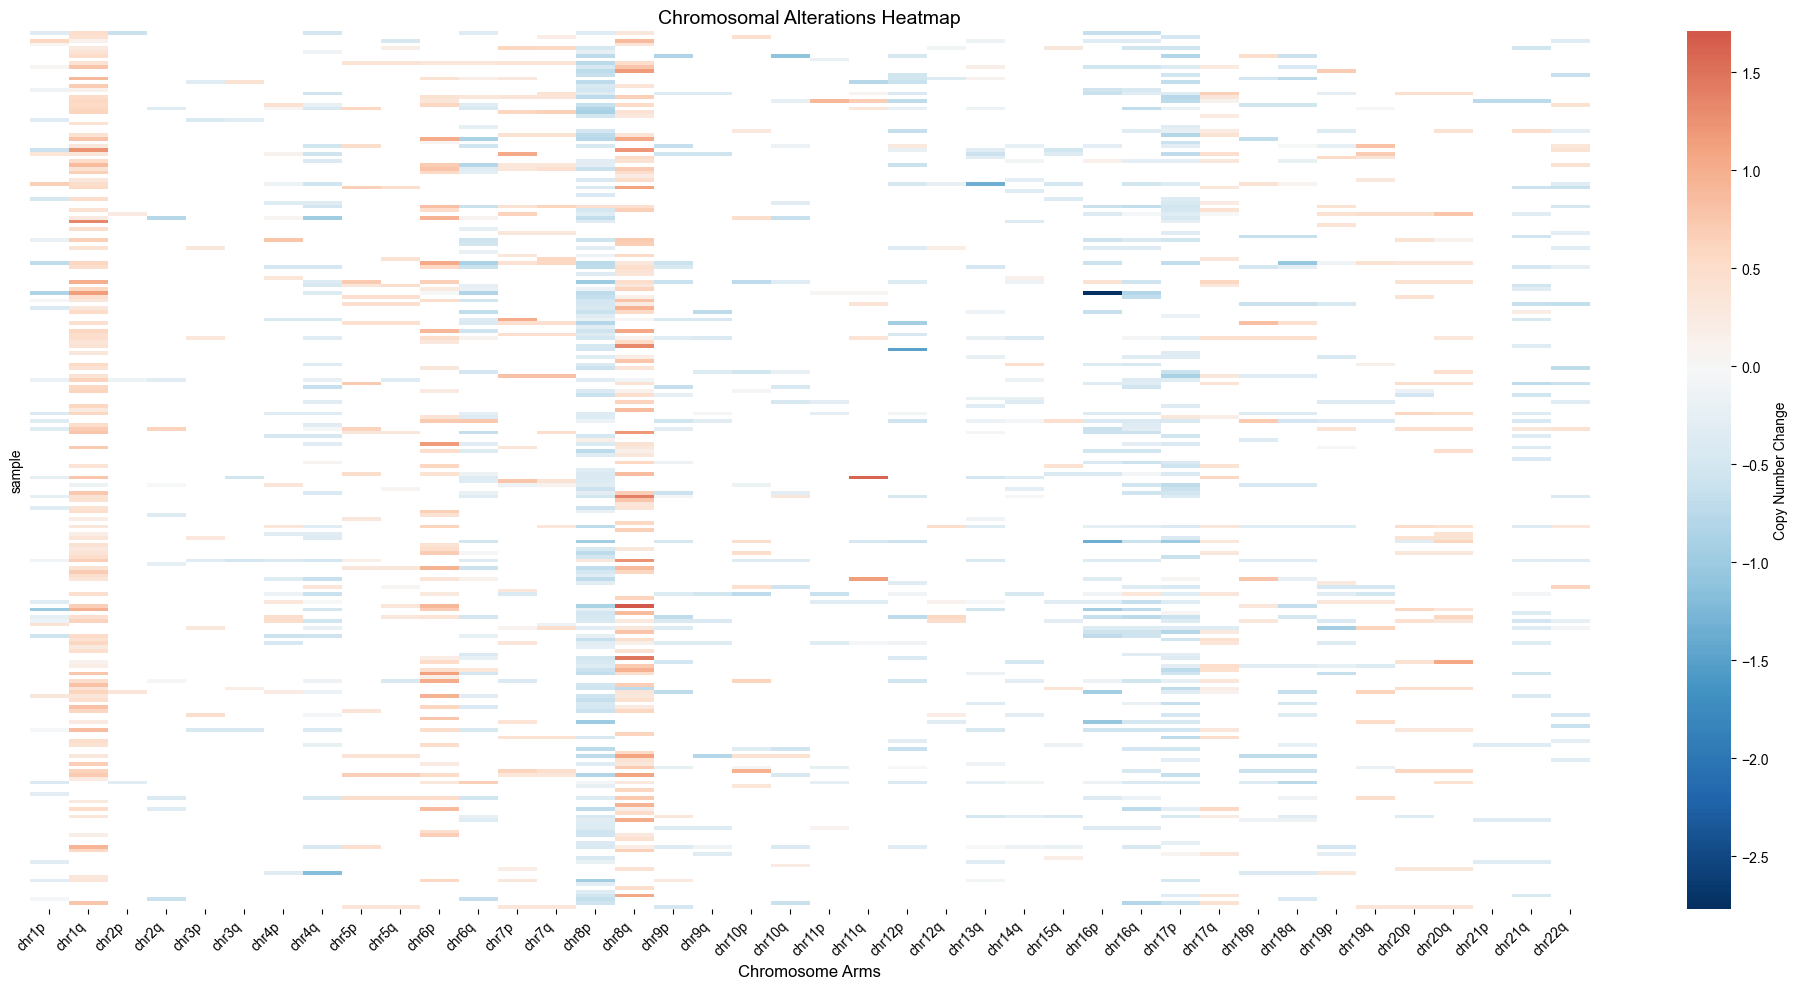


Chromosome arms present in the dataset:
['chr1p', 'chr1q', 'chr2p', 'chr2q', 'chr3p', 'chr3q', 'chr4p', 'chr4q', 'chr5p', 'chr5q', 'chr6p', 'chr6q', 'chr7p', 'chr7q', 'chr8p', 'chr8q', 'chr9p', 'chr9q', 'chr10p', 'chr10q', 'chr11p', 'chr11q', 'chr12p', 'chr12q', 'chr13q', 'chr14q', 'chr15q', 'chr16p', 'chr16q', 'chr17p', 'chr17q', 'chr18p', 'chr18q', 'chr19p', 'chr19q', 'chr20p', 'chr20q', 'chr21p', 'chr21q', 'chr22q']


In [10]:
# -------------------------------------------------------------
# Step 6: Heatmap of chromosomal alterations
# -------------------------------------------------------------

plt.figure(figsize=(20, 10))

pivot_data = df.pivot(
    index="sample",
    columns="chrom_arm",
    values="median_bpWeighted",
)

sns.heatmap(
    pivot_data,
    cmap="RdBu_r",
    center=0,
    cbar_kws={"label": "Copy Number Change"},
    xticklabels=True,
    yticklabels=False,
)

plt.title("Chromosomal Alterations Heatmap", fontsize=14)
plt.xlabel("Chromosome Arms", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\nChromosome arms present in the dataset:")
print(existing_arms)
